In [1]:
# Add PyDatAnalysis to path
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/owensheekey/Documents/Research/PyDatAnalysis")

export_path = 'Exports/'

In [23]:
from __future__ import annotations
from progressbar import progressbar
from src.DatObject.Make_Dat import get_dat, get_dats
import src.UsefulFunctions as U
from src.DataStandardize.ExpSpecific.Feb21 import Feb21Exp2HDF, Feb21ExpConfig
from src.DataStandardize.ExpConfig import ExpConfigGroupDatAttribute, ExpConfigBase
import multiprocessing as mp
import plotly.graph_objs as go
import numpy as np
import lmfit as lm
from typing import TYPE_CHECKING, Iterable, Optional
from src.DatObject.Attributes.Transition import i_sense_digamma, i_sense
from src.UsefulFunctions import edit_params
from src.DatObject.Attributes.SquareEntropy import square_wave_time_array, integrate_entropy
import logging
logger = logging.getLogger(__name__)

In [59]:
dats = get_dats(range(1543, 1556))

In [60]:
[dat.AWG.max(0) for dat in dats]

Need to make _init_mags more permanent...


[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]

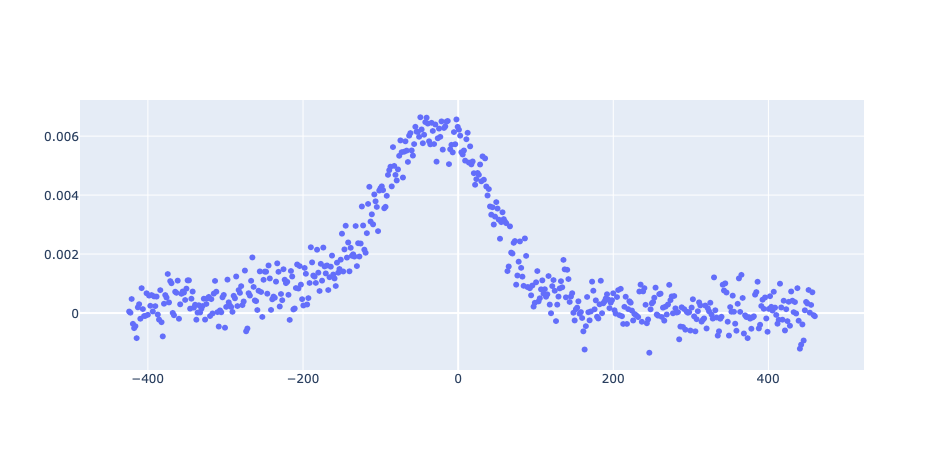

In [61]:
fig = go.Figure()
num = 11
dats[num].SquareEntropy.avg_entropy_signal
fig.add_trace(go.Scatter(mode='markers', x=dats[num].SquareEntropy.avg_x, y=dats[num].SquareEntropy.avg_entropy_signal))
fig.show()

In [6]:
# Tim's get Entropy function
def do_calc(datnum):
    """Just a function which can be passed to a process pool for faster calculation"""
    save_name = 'SPS.0045'

    dat = get_dat(datnum)

    setpoints = [0.0045, None]

    # Get other inputs
    setpoint_times = square_wave_time_array(dat.SquareEntropy.square_awg)
    sp_start, sp_fin = [U.get_data_index(setpoint_times, sp) for sp in setpoints]
    logger.debug(f'Setpoint times: {setpoints}, Setpoint indexs: {sp_start, sp_fin}')

    # Run Fits
    pp = dat.SquareEntropy.get_ProcessParams(name=None,  # Start from default and modify from there
                                             setpoint_start=sp_start, setpoint_fin=sp_fin,
                                             transition_fit_func=i_sense,
                                             save_name=save_name)
    out = dat.SquareEntropy.get_Outputs(name=save_name, inputs=None, process_params=pp, overwrite=False)
    dat.Entropy.get_fit(which='avg', name=save_name, data=out.average_entropy_signal, x=out.x, check_exists=False)
    [dat.Entropy.get_fit(which='row', row=i, name=save_name,
                         data=row, x=out.x, check_exists=False) for i, row in enumerate(out.entropy_signal)]


In [62]:
for dat in progressbar(dats):
    do_calc(dat.datnum)

 84% (11 of 13) |####################    | Elapsed Time: 0:00:47 ETA:   0:00:10/Users/owensheekey/Documents/Research/PyDatAnalysis/src/DatObject/Attributes/Entropy.py:34: RuntimeWarning:

overflow encountered in cosh

100% (13 of 13) |########################| Elapsed Time: 0:00:57 Time:  0:00:57


In [63]:
ents = [dat.Entropy.get_fit(which='avg', name="SPS.0045").best_values.dS for dat in dats]
escs = [dat.Logs.fds["ESC"] for dat in dats]

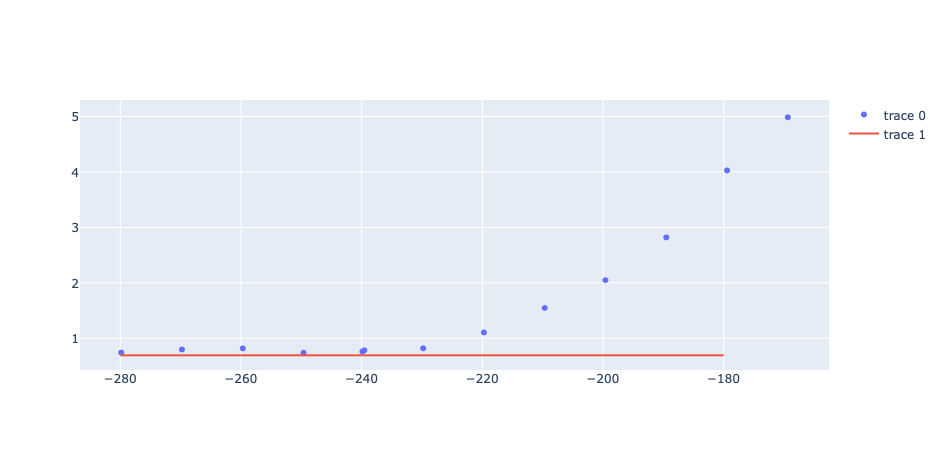

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', x=escs, y=ents))
fig.add_trace(go.Scatter(mode='lines', x=[-280,-180], y=[np.log(2), np.log(2)]))
fig.show()

In [65]:
Θ = dats[0].SquareEntropy.avg_fit.best_values.theta 
fit = dats[0].SquareEntropy.get_fit(which='avg', which_fit='transition', transition_part='cold')
params = fit.params
params.add('g', value=0, vary=True, min=-50, max=1000)
new_pars = edit_params(params, param_name='theta', value=Θ, vary=False) # Based on some old DC bias scans

amp_digamma_ = [dat.SquareEntropy.get_fit(
    which='avg', 
    which_fit='transition', 
    transition_part='cold', 
    initial_params=params, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.amp
for dat in dats]

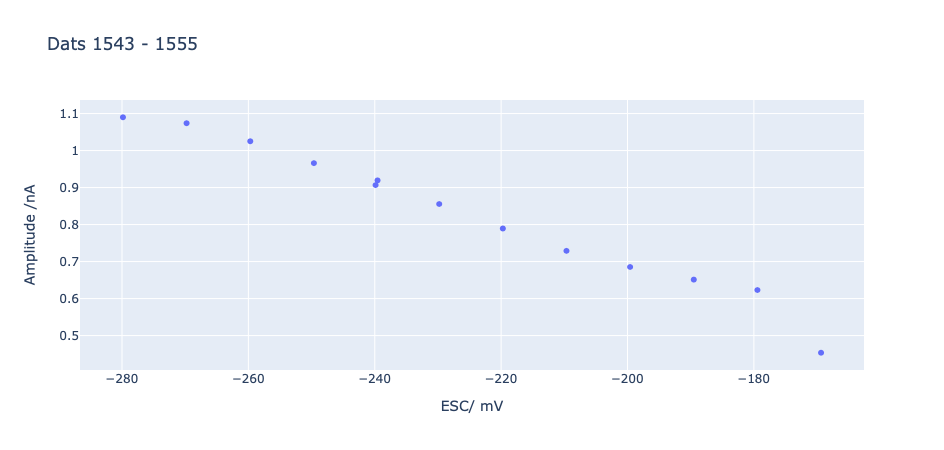

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', x=escs, y=amp_digamma_, text=[dat.datnum for dat in dats], name="Data"))
fig.update_layout(xaxis_title='ESC/ mV', yaxis_title='Amplitude /nA',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')

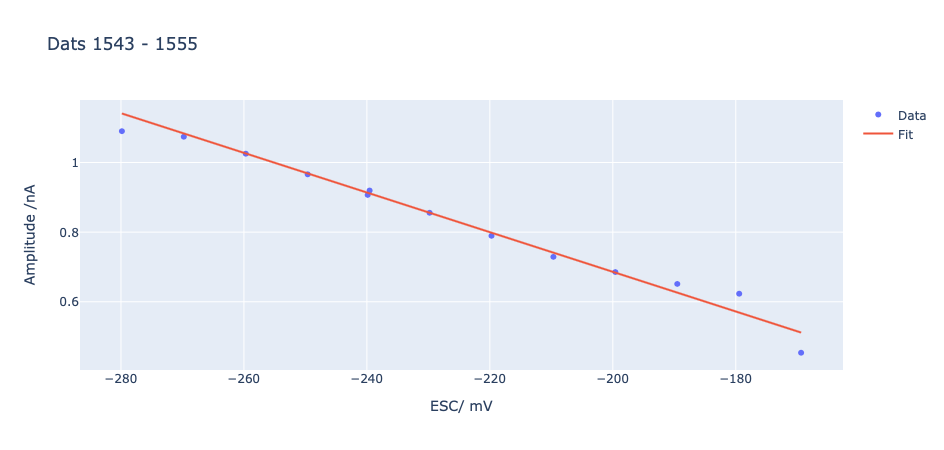

In [71]:
res = np.polyfit(escs[2:], amp_digamma_[2:], 1)
fit = np.polyval(res, escs)
fig.add_trace(go.Scatter(mode='lines', x=escs, y=fit, name="Fit"))

In [69]:
fig.show(renderer='browser')
fig.write_html("Exports/Amplitude_5na_03_05.html")
print(res)
# [-0.00512387 -0.3237704 ]

[-0.00569453 -0.45292353]


In [79]:
g_digamma_ = [dat.SquareEntropy.get_fit(
    which='avg', 
    which_fit='transition', 
    transition_part='cold', 
    initial_params=params, 
    fit_func=i_sense_digamma, 
    check_exists=True).best_values.g
for dat in dats]

In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', x=escs, y=g_digamma_/Θ, text=[dat.datnum for dat in dats]))
fig.update_layout(xaxis_title='ESC/ mV', yaxis_title='Gamma/Theta /Arb',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer='browser')
fig.write_html("Exports/Gamma_03_05_5nA.html")

In [74]:
def get_deltaT(dat):
    """Returns deltaT of a given dat in mV"""
    ho1 = dat.AWG.max(0)  # 'HO1/10M' gives nA * 10
    t = dat.Logs.temps.mc

    # Datnums to search through (only thing that should be changed)
    datnums = set(range(1312, 1451+1)) - set(range(1312, 1451+1, 4))
    # datnums = set()
    # for j in range(5):
    #     datnums = datnums.union(set(range(28 * j + 1312, 28 * j + 1312 + 4 * 7 + 1)) - set([28 * j + 1312 + 4 * i for i in range(8)]))
    # datnums = list(datnums)

    dats = get_dats(datnums)

    dats = [d for d in dats if np.isclose(d.Logs.temps.mc, dat.Logs.temps.mc, rtol=0.1)]  # Get all dats where MC temp is within 10%
    bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])

    indp = np.argmin(abs(bias_lookup - ho1))
    indm = np.argmin(abs(bias_lookup + ho1))
    theta_z = np.nanmean([d.Transition.avg_fit.best_values.theta for d in dats if d.Logs.fds['HO1/10M'] == 0])

    # temp_lookup = np.array([d.Logs.temps.mc for d in dats])
    # bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])
    #
    # indp = np.argmin(temp_lookup - t + bias_lookup - ho1)
    # indm = np.argmin(temp_lookup - t + bias_lookup + ho1)
    # indz = np.argmin(temp_lookup - t + bias_lookup)

    theta_p = dats[indp].Transition.avg_fit.best_values.theta
    theta_m = dats[indm].Transition.avg_fit.best_values.theta
    # theta_z = dats[indz].Transition.avg_fit.best_values.theta
    return (theta_p + theta_m) / 2 - theta_z

In [81]:
deltaT = [get_deltaT(dat) for dat in dats]
ampl = np.multiply(-0.00512387, escs) + -0.3237704
for i, dat in enumerate(dats):
    dat.Entropy.set_integration_info(dT=deltaT[i], amp=ampl[i], overwrite=True)

In [82]:
fig = go.Figure()
for i in range(len(dats)):
    fig.add_trace(go.Scatter(mode='markers', 
                             x=dats[i].SquareEntropy.avg_x, 
                             y=integrate_entropy(dats[i].SquareEntropy.avg_entropy_signal, dats[i].Entropy.integration_info.sf),
                             name= f'Gamma/Theta /arb = {np.divide(g_digamma_,Θ)[i]:.2f}'))

fig.add_trace(go.Scatter(mode='lines', x=[-400,400], y=[np.log(2), np.log(2)], name="Log2"))  
fig.add_trace(go.Scatter(mode='lines', x=[-400,400], y=[np.log(3), np.log(3)], name="Log3"))  
fig.update_layout(xaxis_title='ACC/100 /mV', yaxis_title='Entropy /kb',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer='browser')

In [83]:
fig.write_html("Exports/Allentropy_03_05_5nA.html")